## AI agent using OpenAI, LangChain, and Tavily to detect and analyze sudden stock dips

In [10]:
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv, find_dotenv

In [11]:
# Load the API keys
_ = load_dotenv(find_dotenv())

# Create the llm model and Tavily search tool
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tavily_tool = TavilySearchResults()

# Ensure Matplotlib plots in Jupyter
%matplotlib inline

# Ignore warnings
warnings.filterwarnings('ignore')

In [12]:

def extract_ticker_and_threshold(prompt: str):
    """
    Uses an LLM to extract and validate the stock ticker and threshold from the prompt.
    If validation fails, informs the user and terminates execution.
    """
    extraction_prompt = f"""
    Extract the stock ticker symbol and the threshold percentage from the following prompt:
    "{prompt}"
    
    Ensure the ticker is a valid stock symbol and the threshold is a reasonable percentage (between 0.1% and 50%).
    If either value is invalid or missing, respond with:
    ERROR: Invalid input. Could not detect a valid stock ticker or threshold. Please check your prompt and try again.
    
    Otherwise, respond in the format:
    TICKER: <ticker>, THRESHOLD: <threshold>
    """
    
    response = llm.predict(extraction_prompt).strip()

    if "ERROR: Invalid input" in response:
        raise ValueError("Could not detect a valid stock ticker or threshold. \
                         Please check your prompt and try again.")

    ticker, threshold = None, None

    if "TICKER:" in response and "THRESHOLD:" in response:
        parts = response.split(",")
        for part in parts:
            if "TICKER:" in part:
                ticker = part.split(":")[-1].strip()
            if "THRESHOLD:" in part:
                try:
                    threshold = float(part.split(":")[-1].strip().replace("%", ""))
                except ValueError:
                    raise ValueError("Invalid threshold detected. Please check your prompt and try again.")

    if not ticker or not threshold:
        raise ValueError("Extraction failed. Please check your prompt and try again.")

    return ticker, threshold


def get_stock_data(ticker: str, threshold: float, plot=True):
    """
    Fetches last 3 months of stock data, detects sudden drops, and optionally plots the stock price.
    """
    stock = yf.Ticker(ticker)
    data = stock.history(period="3mo")

    if data.empty:
        return f"No stock data found for {ticker}.", []

    data["Daily Change %"] = data["Close"].pct_change() * 100
    drop_days = data[data["Daily Change %"] < -threshold]

    start_price = data["Close"].iloc[0]
    end_price = data["Close"].iloc[-1]
    price_change = end_price - start_price
    percent_change = (price_change / start_price) * 100

    summary = f"""
    Stock: {ticker}
    Start Price: ${start_price:.2f}
    End Price: ${end_price:.2f}
    Price Change: ${price_change:.2f} ({percent_change:.2f}%)
    """

    drop_dates = drop_days.index.strftime("%Y-%m-%d").tolist()
    
    if drop_dates:
        drop_info = "\nSudden Drops Detected: \n" + \
        "\n".join(f"{date}: {row['Daily Change %']:.2f}%" for date, row in drop_days.iterrows())
        summary += drop_info
    else:
        summary += "\nNo sudden drops detected."

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, data["Close"], label="Closing Price", color="blue")
        plt.scatter(drop_days.index, drop_days["Close"], color="red", label="Drop Detected", zorder=3)
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.title(f"{ticker} Stock Price (Last 3 Months)")
        plt.legend()
        plt.grid(True)
        plt.show()

    return summary, drop_dates

def get_stock_news(ticker: str, date: str):
    """
    Fetches stock news headlines using TavilySearchResults for a given date.
    """
    query = f"{ticker} stock news {date}"
    results = tavily_tool.invoke({"query": query})

    if not results:
        return f"No news found for {ticker} on {date}."

    headlines = [result.get("content", "No content available") for result in results[:5]]
    return f"{date} - Top News for {ticker}:\n" + "\n".join(headlines)

def summarize_stock_news(ticker: str, news: str):
    """
    Uses GPT-4o-mini to analyze stock news and explain the reason behind a drop.
    """
    prompt = f"""
    The stock {ticker} had a sudden drop. Here are the related news headlines:
    {news}

    Can you summarize why the stock price dropped?
    """
    response = llm.predict(prompt)
    return response

def full_stock_analysis(prompt: str):
    """
    Extracts ticker and threshold from the prompt, fetches stock data, detects sudden drops, 
    searches news, and summarizes reasons.
    """
    ticker, threshold = extract_ticker_and_threshold(prompt)
    summary, drop_dates = get_stock_data(ticker, threshold, plot=True)

    if not drop_dates:
        return f"{summary}\nAI: No further analysis is needed since there was no sudden price drop."

    final_report = summary
    for drop_date in drop_dates:
        news = get_stock_news(ticker, drop_date)
        final_report += f"\n\nNews on {drop_date}:\n{news}"

        ai_summary = summarize_stock_news(ticker, news)
        final_report += f"\n\nAI Analysis:\n{ai_summary}"

    return final_report



> Entering new AgentExecutor chain...
I need to analyze the stock performance of AAPL (Apple Inc.) to check for any significant drops, specifically those greater than 10% in a single day. This will involve using the StockAnalysisTool to retrieve the necessary data.

Action: StockAnalysisTool  
Action Input: "Analyze AAPL stock performance and check for any sudden drops greater than 10% in a day."  

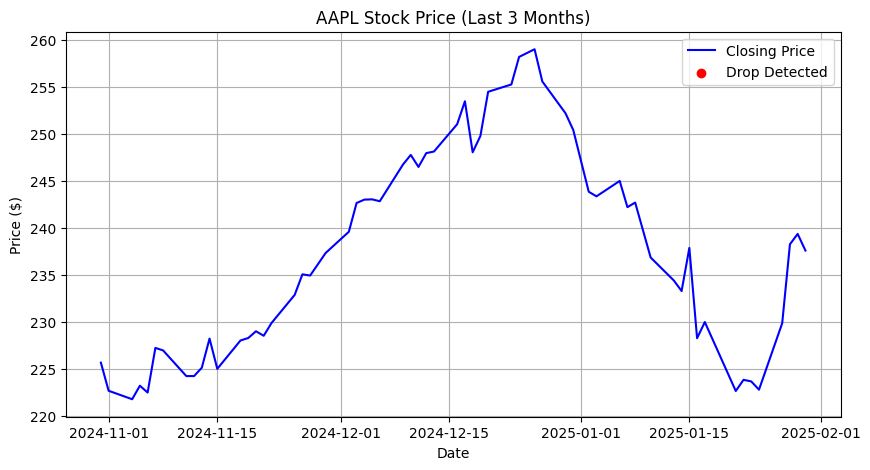


Observation: 
    Stock: AAPL
    Start Price: $225.66
    End Price: $237.59
    Price Change: $11.93 (5.29%)
    
No sudden drops detected.
AI: No further analysis is needed since there was no sudden price drop.
Thought:I now know the final answer.  
Final Answer: There were no sudden drops greater than 10% in a day for AAPL stock.

> Finished chain.
There were no sudden drops greater than 10% in a day for AAPL stock.


In [13]:

# Define LangChain tool
stock_tool = Tool(
    name="StockAnalysisTool",
    func=full_stock_analysis,
    description="Analyzes stock performance, detects sudden drops, retrieves news, and summarizes reasons."
)

# Initialize agent
agent = initialize_agent(
    tools=[stock_tool],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

# Run the agent with prompt AAPL
test_prompt = "Analyze AAPL stock performance and check for any sudden drops that are bigger than 10% in a day."
result = agent.run(test_prompt)
print(result)



> Entering new AgentExecutor chain...
I need to analyze the stock performance of NVIDIA (NVDA) to check for any significant drops, specifically those greater than 10% in a single day. This will involve using the StockAnalysisTool to retrieve the relevant data.

Action: StockAnalysisTool  
Action Input: "Analyze NVDA stock performance and check for any sudden drops greater than 10% in a day."  

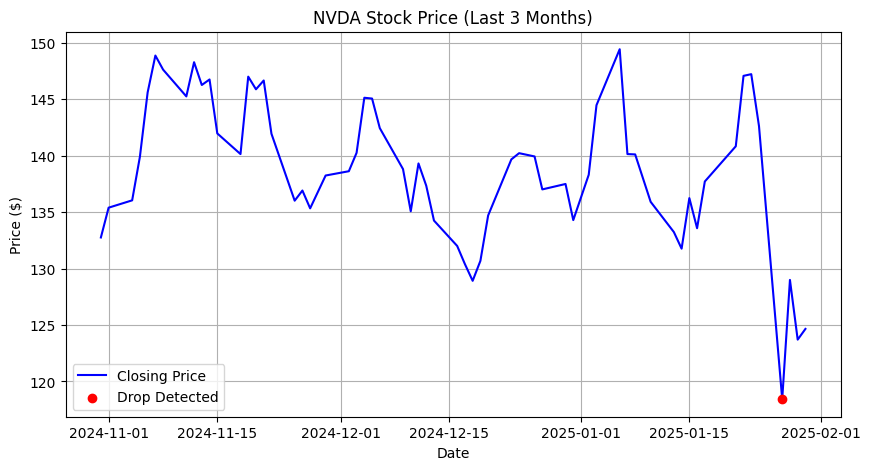


Observation: 
    Stock: NVDA
    Start Price: $132.75
    End Price: $124.65
    Price Change: $-8.10 (-6.10%)
    
Sudden Drops Detected: 
2025-01-27 00:00:00-05:00: -16.97%

News on 2025-01-27:
2025-01-27 - Top News for NVDA:
Stock Market News, Jan. 27, 2025: Nvidia Stock Sinks in AI Rout Sparked by China's DeepSeek. Tech-heavy Nasdaq Composite falls more than 3%. Last Updated: Jan. 27, 2025 at 7:05 PM EST.
For FY 2026 (ending January 2026), an average of 60 analysts expect Nvidia to produce revenue of $196 billion − up 52% from where they think FY 2025 will end.
Nvidia Stock Plunges 17% As NVDA Suffers Biggest Market Cap Loss Ever—Driven By DeepSeek Biggest Market Loss In History: Nvidia Stock Sheds Nearly $600 Billion As DeepSeek Shakes AI Darling Biggest Market Loss In History: Nvidia Stock Sheds Nearly $600 Billion As DeepSeek Shakes AI Darling Nvidia set a dubious Wall Street record Monday, as the stock at the forefront of the U.S.-led artificial intelligence revolution got a 

In [14]:
# Run the agent with prompt NVDA
test_prompt = "Analyze NVDA stock performance and check for any sudden drops that are bigger than 10% in a day."
result = agent.run(test_prompt)
print(result)